# Fuzzy C means Clustering 



One important aspect of fuzzy c means that changes the results significantly is the initialization. So you should run the fuzzy c-means algorithm with the given initialization below above 100 times. The final output of the clustering is the result that gives the minimum  J.
One possible startegy for intialization cluster centers is to select the furthest points from each other. 
it's required to try clustering with different q (the fuzziness Index and visualize the results)


<font color=blue size=4>1-Needed Packages

In [54]:
import numpy as np
import matplotlib.pylab as plt
import math
import pandas as pd
from numpy.random import seed
import sys
ep = sys.float_info.epsilon

<font color=blue size=4>2-Load Data

In [55]:
def Random_Select(data):
    """
    This Function should implement step 1 in slide 15, Lec 6
    Input: Dataset
    Return: 3-means
    """
    # slide 15, Lec 6 states that we should pick all clusters centroids at random 
    # but to improve the initial solution and reduce the number of iterations 
    # we could just select the first cluster centroid at random, 
    # and pick the other two centroids as the farthest to this one  
    m1=data[np.random.randint(len(data))-1,:]
    dist=(np.sum((data-m1)**2,axis=1))**0.5
    #2. select the second one as the farthest
    m2=data[np.argmax(dist),:]
    #3. select the third one as the second farthest
    dist[np.argmax(dist)]=0
    m3=data[np.argmax(dist),:]
    
    return m1,m2,m3 

In [56]:
def Membership(data,m1,m2,m3, q):
    """
    This function should implement step 2 in slide 15, Lec 6
    Possible values for rnk will be any value between [0,1] 
    Input: Dataset, 3-means, membership matrix, and the fuzziness Index
    Return: New membership matrix with shape (len(data), 3)
    ** hint: the distance between the cluster mean point and itself is zero,
        it will result NANs and INFs in the rnk equation, 
        you can add epsilon to the distances in you rnk computations
    """
    eps = 1e-8
    rnk=np.zeros((len(data),3)) # Membership Vector
    # ||X-m1||^2 ,||X-m2||^2, ||X-m3||^2
    data_m1 = np.sum((data - m1)**2,axis=1)
    data_m1[data_m1==0]=eps
    data_m2 = np.sum((data - m2)**2,axis=1)
    data_m2[data_m2==0]=eps
    data_m3 = np.sum((data - m3)**2,axis=1)
    data_m3[data_m3==0]=eps


    for i in range(len(data)):
        rnk[i,0]= 1 / ( 1 + np.power(data_m1[i]/(data_m2[i]),1/(q-1)) + np.power(data_m1[i]/(data_m3[i]),1/(q-1)) ) 
        rnk[i,1]= 1 / ( np.power(data_m2[i]/(data_m1[i]),1/(q-1)) + 1 + np.power(data_m2[i]/(data_m3[i]),1/(q-1)) ) 
        rnk[i,2]= 1 / ( np.power(data_m3[i]/(data_m1[i]),1/(q-1)) + np.power(data_m3[i]/(data_m2[i]),1/(q-1)) + 1 ) 
    
    return rnk


In [57]:
def Update_Means(data,rnk,q):
    """
    This function should implement step 3 in slide 15, Lec 6
    
    Input: Dataset, membership vector, and the fuzziness index
    Return: updated 3-means
    """
    # rnk^q columns sum
    rnkSum = np.sum(np.power(rnk,q),axis=0)
    m1 = np.power(rnk[:,0],q).T.dot(data) / rnkSum[0]
    m2 = np.power(rnk[:,1],q).T.dot(data) / rnkSum[1]
    m3 = np.power(rnk[:,2],q).T.dot(data) / rnkSum[2]
    return m1,m2,m3


In [58]:
def Objective_Function(data,rnk,m1,m2,m3, q):
    """
    This function should implement  objective Function in slide 13,Lec 6
    
    Input: Dataset, membership matrix, 3-means, and the fuzziness index
    Return: Total Average Distance
    """
    data_m1 = np.power(rnk[:,0],q)*np.sum((data - m1)**2,axis=1) 
    data_m2 = np.power(rnk[:,1],q)*np.sum((data - m2)**2,axis=1)
    data_m3 = np.power(rnk[:,2],q)*np.sum((data - m3)**2,axis=1)

    data_m1Sum = np.sum(data_m1)
    data_m2Sum = np.sum(data_m2)
    data_m3Sum = np.sum(data_m3)
    
    return data_m1Sum + data_m2Sum + data_m3Sum

In [59]:
def Stopping_Criteria(m1_b,m2_b,m3_b,m1,m2,m3):
    """
    This function should Test Convergence
    
    Input:  3-means before updating and after it.
    Return: return True or return False
    ** hint: unlike this step in the k means algorithm,
            you need to compute the difference between the old and new means,
            and compare the difference to a very small threshold, 
            or your can compare after rounding the means to 4 of 5 decimal places.
    """

    if (np.array_equal(np.around(m1, decimals=5),np.around(m1_b, decimals=5))) and \
       (np.array_equal(np.around(m2, decimals=5),np.around(m2_b, decimals=5))) and \
       (np.array_equal(np.around(m3, decimals=5),np.around(m3_b, decimals=5))):
        return True
    else:
        return False
    


In [60]:
#________________________Main Code Statrs here___________________________________
def myFCM(data, q):
        assert q > 1
        m1f,m2f,m3f=np.zeros((2,100)),np.zeros((2,100)),np.zeros((2,100)) # 3 - Means 

        Avgdist=np.zeros((100,))
        counter=0

        while(counter <100):
            
                # --------------------Intialization Step 1------------------------------#
                seed(counter)
                m1,m2,m3 = Random_Select(data)

                rnk = np.zeros(len(data)) # Membership Vector

                m1_b = m1
                m2_b = m2
                m3_b = m3
                cc = 0
                while(True):
                    #---------------Step 2 compute rnk-----------------------------------------#

                    rnk = Membership(data,m1,m2,m3, q)

                    assert all(np.round(np.sum(rnk, axis = 1), 2) == np.ones(len(rnk)))

                    #---------------Step 3 update means-----------------------------------------#

                    m1,m2,m3 = Update_Means(data,rnk, q)

                    #---------------Step 4 Test Convergence -----------------------------------------#

                    if Stopping_Criteria(m1_b,m2_b,m3_b,m1,m2,m3):
                         m1f[:,counter],m2f[:,counter],m3f[:,counter] = m1,m2,m3

                         Avgdist[counter] = Objective_Function(data,rnk,m1,m2,m3, q)
                         break


                    m1_b = m1
                    m2_b = m2
                    m3_b = m3

                counter += 1     

        idx = np.argmin(Avgdist)
        m1_ = m1f[:,idx]
        m2_ = m2f[:,idx]
        m3_ = m3f[:,idx]
        rnk_=np.argmax(Membership(data,m1_,m2_,m3_, q), axis = 1)
        return rnk_, m1_, m2_, m3_

In [61]:
# Load Data
df = pd.read_csv('clustering_assignmentData.csv')
data = df[['X1', 'X2']].values
y = df['y'].values

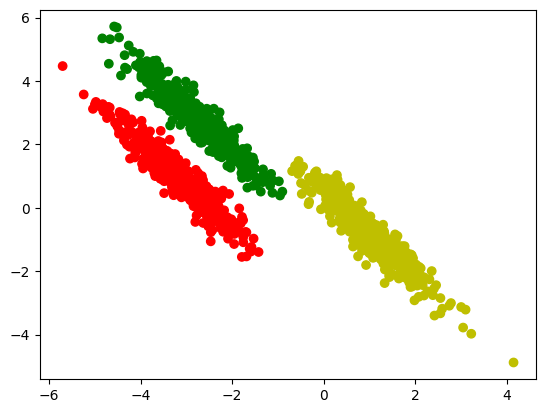

In [62]:
plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), y)))

# Plotting 

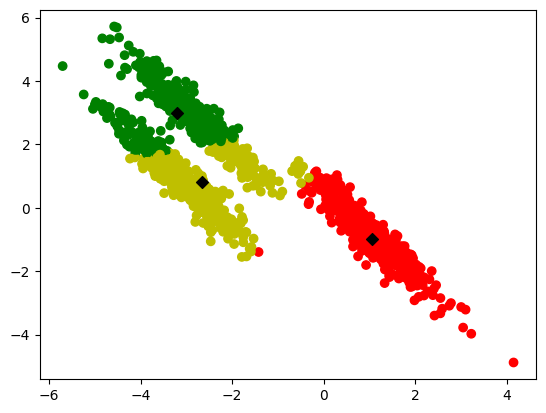

In [63]:
# Plotting the Final Centroids and data. 
q = 2
rnk_ , m1_, m2_, m3_= myFCM(data, q)
plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), rnk_)))
plt.scatter([m1_[0], m2_[0],m3_[0]],[m1_[1], m2_[1], m3_[1]], marker = 'D', c = 'black')


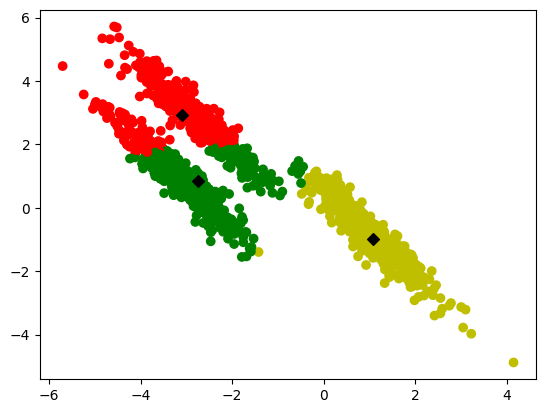

In [64]:
q = 3
rnk_ , m1_, m2_, m3_= myFCM(data, q)

plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), rnk_)))
plt.scatter([m1_[0], m2_[0],m3_[0]],[m1_[1], m2_[1], m3_[1]], marker = 'D', c = 'black')

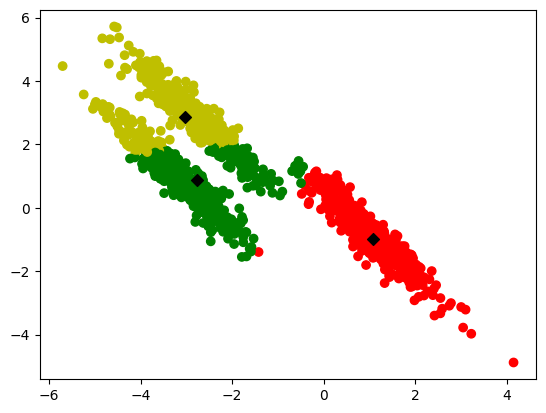

In [65]:
q = 4
rnk_ , m1_, m2_, m3_= myFCM(data, q)

plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), rnk_)))
plt.scatter([m1_[0], m2_[0],m3_[0]],[m1_[1], m2_[1], m3_[1]], marker = 'D', c = 'black')

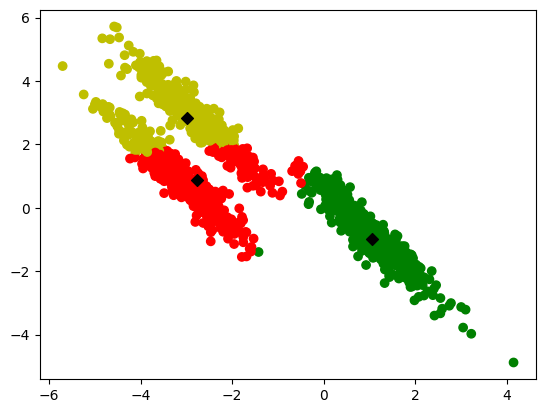

In [66]:
q = 5
rnk_ , m1_, m2_, m3_= myFCM(data, q)

plt.scatter(data[:, 0],data[:, 1], color = list(map(lambda x: {0:'r', 1: 'g', 2: 'y'}.get(x), rnk_)))
plt.scatter([m1_[0], m2_[0],m3_[0]],[m1_[1], m2_[1], m3_[1]], marker = 'D', c = 'black')